In [60]:
import h5py
import scipy.io as io
from PIL import Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from tqdm import tqdm
import scipy.spatial

from matplotlib import cm as CM
%matplotlib inline

In [61]:
def gaussian_filter_density(gt):
    
    """
    Generates a density map using Gaussian filter transformation
    """
    
    density = np.zeros(gt.shape, dtype=np.float32)
    
    gt_count = np.count_nonzero(gt)
    
    if gt_count == 0:
        return density

    # Find out the K nearest neighbours using a KDTree
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)
        
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        
        #Convolve with the gaussian filter
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    
    return density

In [62]:
#set the root to the Shanghai dataset you download
root = 'C:/Users/Natalie/Documents/NUS modules/CS3244/project/ShanghaiTech/'

In [63]:
part_A_train = os.path.join(root, 'part_A_final/train_data', 'images')
part_A_test = os.path.join(root, 'part_A_final/test_data', 'images')
part_B_train = os.path.join(root, 'part_B_final/train_data', 'images')
part_B_test = os.path.join(root, 'part_B_final/test_data', 'images')
path_sets_A = [part_A_train, part_A_test]
path_sets_B = [part_B_train, part_B_test]

img_paths_A = []
for path in path_sets_A:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_A.append(img_path)

img_paths_B = []
for path in path_sets_B:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_B.append(img_path)

## Generating HDF5 files for:

#### SHT Part A

In [14]:
for img_path in tqdm(img_paths_A):
           
    # Load sparse matrix
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    
    #Read image
    img= plt.imread(img_path)
    
    # Create a zero matrix of image size
    k = np.zeros((img.shape[0],img.shape[1]))
    
    gt = mat["image_info"][0,0][0,0][0]
    
    #Generate hot encoded matrix of sparse matrix
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    
    # generate density map
    k = gaussian_filter_density(k)
    
    # File path to save density map
    file_path = img_path.replace('.jpg','.h5').replace('images','ground_truth')
    
    with h5py.File(file_path, 'w') as hf:
            hf['density'] = k

100%|██████████████████████████████████████████████████████████████████████████████| 482/482 [4:15:19<00:00, 31.78s/it]


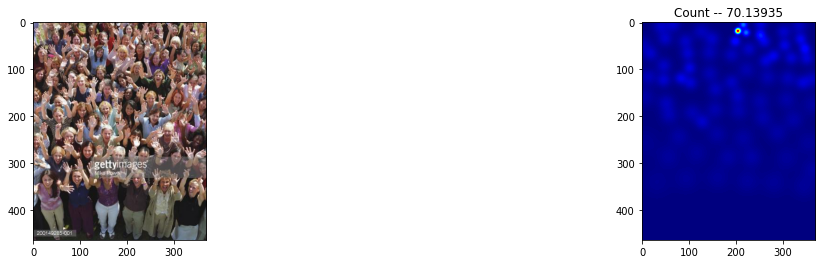

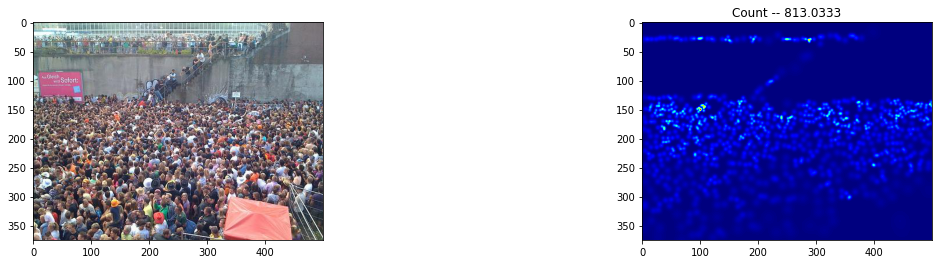

In [65]:
# Show a sample
img_paths = [img_paths_A[184],img_paths_A[200]]

for img_path in img_paths:
    
    gt_file = h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])

    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(Image.open(img_path))
    
    ax1.imshow(groundtruth,cmap=CM.jet)
    ax1.set_title('Ground Truth: '+str(np.sum(groundtruth)))
    
    plt.show()

#### SHT Part B

In [66]:
for img_path in tqdm(img_paths_B):
           
    # Load sparse matrix
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    
    #Read image
    img= plt.imread(img_path)
    
    # Create a zero matrix of image size
    k = np.zeros((img.shape[0],img.shape[1]))
    
    gt = mat["image_info"][0,0][0,0][0]
    
    #Generate hot encoded matrix of sparse matrix
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    
    # generate density map
    k = gaussian_filter_density(k)
    
    # File path to save density map
    file_path = img_path.replace('.jpg','.h5').replace('images','ground_truth')
    
    with h5py.File(file_path, 'w') as hf:
            hf['density'] = k

100%|██████████████████████████████████████████████████████████████████████████████| 716/716 [3:11:50<00:00, 16.08s/it]


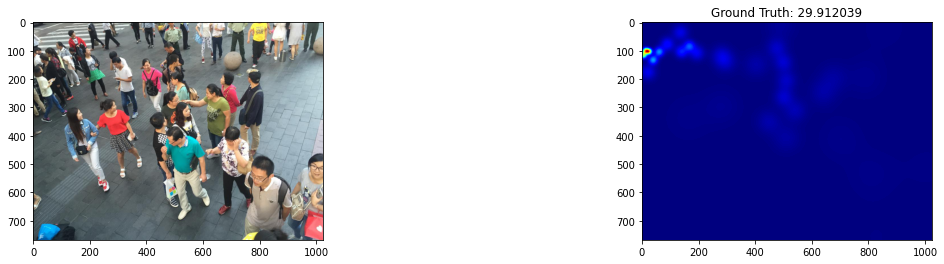

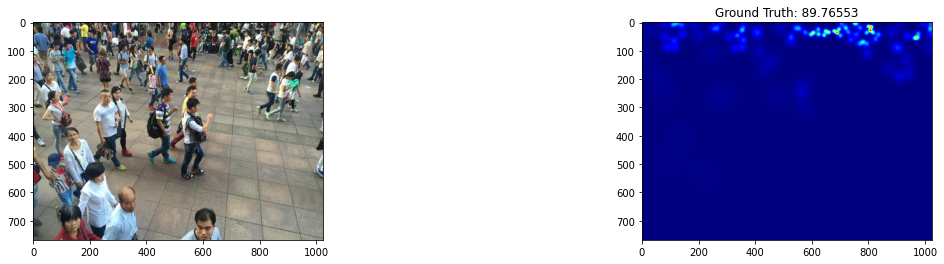

In [68]:
# Show a sample
img_paths = [img_paths_B[184],img_paths_B[200]]

for img_path in img_paths:
    
    gt_file = h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])

    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(Image.open(img_path))
    
    ax1.imshow(groundtruth,cmap=CM.jet)
    ax1.set_title('Ground Truth: '+str(np.sum(groundtruth)))
    
    plt.show()